Importación de paquetes

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# importar archivos
crossBattlelog = pd.read_parquet('datasets/teams/battlelog_teams.parquet')
crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232544 entries, 0 to 232544
Data columns (total 44 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   battleTime                             232544 non-null  datetime64[ns]
 1   playertag                              232544 non-null  object        
 2   event_mode                             232544 non-null  object        
 3   event_map                              232544 non-null  object        
 4   battle_type                            232544 non-null  object        
 5   battle_result                          232544 non-null  object        
 6   battle_duration                        232544 non-null  int16         
 7   battle_trophyChange                    187424 non-null  Float64       
 8   battle_team1_player1_tag               232544 non-null  object        
 9   battle_team1_player1_name              232544 no

In [7]:
# leer brawler stats
brawlers = pd.read_parquet('datasets/brawlers/brawlers_stats.parquet')
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              64 non-null     int64  
 1   name            64 non-null     object 
 2   Brawler         64 non-null     object 
 3   Health          64 non-null     float64
 4   Rarity          64 non-null     object 
 5   Class           64 non-null     object 
 6   Movement_Speed  64 non-null     object 
 7   Range           63 non-null     object 
 8   Reload          63 non-null     object 
 9   Speed_Num       64 non-null     int64  
 10  Range_Num       64 non-null     float64
 11  Reload_Num      63 non-null     float64
 12  Role            64 non-null     object 
dtypes: float64(3), int64(2), object(8)
memory usage: 6.6+ KB


In [8]:
# leer datos de mapa
bushList = pd.read_csv('datasets/maps/bushList.csv', index_col=0)
bushList.columns = bushList.columns.str.replace('.', '_', regex=True)
waterList = pd.read_csv('datasets/maps/waterList.csv', index_col=0)
waterList.columns = waterList.columns.str.replace('.', '_', regex=True)
barrierList = pd.read_csv('datasets/maps/barrierList.csv', index_col=0)
barrierList.columns = barrierList.columns.str.replace('.', '_', regex=True)

In [9]:
# leer brawler winrate y userate
brawler_wr_ur = pd.read_parquet('datasets/teams/brawler_winrate_userate.parquet')
brawler_wr_ur_overall = pd.read_parquet('datasets/teams/brawler_winrate_userate_overall.parquet')

In [10]:
# leer player stats
players = pd.read_parquet('datasets/players/players.parquet')
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286093 entries, 0 to 1286092
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   tag              1286093 non-null  object        
 1   team_victories   1286093 non-null  int64         
 2   highestTrophies  1286093 non-null  int64         
 3   expPoints        1286093 non-null  int64         
 4   trophies         1286093 non-null  int64         
 5   datetime         1286093 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 58.9+ MB


In [11]:
# función para identificar a que team pertenece el player
def team_assignment(row):
    if any(row['playertag'] == tag for tag in [row.battle_team1_player1_tag, row.battle_team1_player2_tag, row.battle_team1_player3_tag]):
        return 1
    elif any(row['playertag'] == tag for tag in [row.battle_team2_player1_tag, row.battle_team2_player2_tag, row.battle_team2_player3_tag]):
        return 2
    else:
        print("error in team assignation for id " + str(row.name))

crossBattlelog['player_team'] = crossBattlelog.apply(team_assignment, axis=1)

crossBattlelog['player_team'].value_counts()

1    121279
2    111265
Name: player_team, dtype: int64

In [12]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['battle_result'] != 'draw'].reset_index(drop=True)

In [13]:
# crear columna winner_team
def winner_assignment(row):
	if row.battle_result == 'draw':
		return 'draw'
	elif (row.player_team == 1 and row.battle_result == 'victory') or (row.player_team == 2 and row.battle_result == 'defeat'):
		return 1
	elif (row.player_team == 2 and row.battle_result == 'victory') or (row.player_team == 1 and row.battle_result == 'defeat'):
		return 2
	else:
		return "error in winner assignation for id " + str(row.name)

crossBattlelog['winner_team'] = crossBattlelog.apply(winner_assignment, axis=1)

crossBattlelog['winner_team'].value_counts()

1    120149
2    110584
Name: winner_team, dtype: int64

In [14]:
# # crear columna winner
# def subset_winner(df, team):

# 	df['winner'] = 'no'

# 	for i, winner_team in enumerate(df['winner_team']):
# 		if winner_team == team:
# 			df.loc[i, 'winner'] = 'yes'

# 	df = df.rename(columns={
# 		'battle_' + team + '_player1_tag': 'battle_player1_tag',
# 		'battle_' + team + '_player1_brawler_name': 'battle_player1_brawler_name',
# 		'battle_' + team + '_player1_brawler_power': 'battle_player1_brawler_power',
# 		'battle_' + team + '_player1_brawler_trophies': 'battle_player1_brawler_trophies',
# 		'battle_' + team + '_player2_tag': 'battle_player2_tag',
# 		'battle_' + team + '_player2_brawler_name': 'battle_player2_brawler_name',
# 		'battle_' + team + '_player2_brawler_power': 'battle_player2_brawler_power',
# 		'battle_' + team + '_player2_brawler_trophies': 'battle_player2_brawler_trophies',
# 		'battle_' + team + '_player3_tag': 'battle_player3_tag',
# 		'battle_' + team + '_player3_brawler_name': 'battle_player3_brawler_name',
# 		'battle_' + team + '_player3_brawler_power': 'battle_player3_brawler_power',
# 		'battle_' + team + '_player3_brawler_trophies': 'battle_player3_brawler_trophies',
# 	})

# 	df = df[[	
# 		'event_mode',
# 		'event_map',
# 		'battle_type',
# 		'battle_duration',
# 		'battle_player1_tag',
# 		'battle_player1_brawler_name',
# 		'battle_player1_brawler_power',
# 		'battle_player1_brawler_trophies',
# 		'battle_player2_tag',
# 		'battle_player2_brawler_name',
# 		'battle_player2_brawler_power',
# 		'battle_player2_brawler_trophies',
# 		'battle_player3_tag',
# 		'battle_player3_brawler_name',
# 		'battle_player3_brawler_power',
# 		'battle_player3_brawler_trophies',
# 		'winner',
# 	]]

# 	return df

# def clean_winner(team):

# 	if team == 'team1':
# 		oteam = 'team2'
# 	else:
# 		oteam = 'team1'
	
# 	subset = crossBattlelog[crossBattlelog['winner_team'] == team].reset_index(drop=True)

# 	dfwinners = subset_winner(subset, team)

# 	dfloosers = subset_winner(subset, oteam)

# 	return pd.concat([dfwinners, dfloosers], ignore_index=True)

# team1 = clean_winner('team1')
# team2 = clean_winner('team2')

# battlelogProcess = pd.concat([team1, team2], ignore_index=True)
# battlelogProcess.info()

In [15]:
# reemplazar valores de movement speed
brawlers['Movement_Speed'] = brawlers['Movement_Speed'].replace('Clyde; Slow', 'Slow')
brawlers['Movement_Speed'].value_counts()

Normal       41
Fast         14
Very Fast     6
Slow          2
Very Slow     1
Name: Movement_Speed, dtype: int64

In [16]:
# reemplazar valores de brawler range
brawlers['Range'] = brawlers['Range'].replace('close range; Normal', 'Short')
brawlers['Range'] = brawlers['Range'].replace('min range; Normal', 'Normal')
brawlers['Range'] = brawlers['Range'].replace('Clyde; Very Long', 'Very Long')

# reemplazar nan por 'Normal'
brawlers['Range'] = brawlers['Range'].fillna('Normal')

brawlers['Range'].value_counts()


Long         28
Very Long    14
Normal       12
Short        10
Name: Range, dtype: int64

In [17]:
# merge brawler stats
batltlelog = crossBattlelog

def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers[['name','Health','Rarity','Class','Movement_Speed','Range','Reload','Speed_Num','Range_Num','Reload_Num','Role']].add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

batltlelog = add_brawlers(batltlelog, 'battle_team1_player1_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team1_player2_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team1_player3_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team2_player1_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team2_player2_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team2_player3_brawler_')

batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230733 entries, 0 to 230732
Columns: 106 entries, battleTime to battle_team2_player3_brawler_Role
dtypes: Float64(19), datetime64[ns](1), float64(24), int16(1), int64(2), object(59)
memory usage: 191.2+ MB


In [18]:
# merge player stats
def merge_playerstats(df, prefix):
	df = pd.merge(left=df, right=players.add_prefix(prefix), on=prefix + 'tag', how='inner')
	return df

batltlelog = merge_playerstats(batltlelog, 'battle_team1_player1_')
batltlelog = merge_playerstats(batltlelog, 'battle_team1_player2_')
batltlelog = merge_playerstats(batltlelog, 'battle_team1_player3_')
batltlelog = merge_playerstats(batltlelog, 'battle_team2_player1_')
batltlelog = merge_playerstats(batltlelog, 'battle_team2_player2_')
batltlelog = merge_playerstats(batltlelog, 'battle_team2_player3_')

batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214438 entries, 0 to 214437
Columns: 136 entries, battleTime to battle_team2_player3_datetime
dtypes: Float64(19), datetime64[ns](7), float64(24), int16(1), int64(26), object(59)
memory usage: 226.8+ MB


In [19]:
# merge map data
batltlelog = batltlelog.merge(barrierList, how='inner', on='event_map')
batltlelog = batltlelog.merge(bushList, how='inner', on='event_map')
batltlelog = batltlelog.merge(waterList, how='left', on='event_map')
batltlelog['waterProp'] = batltlelog['waterProp'].fillna(0)
batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165935 entries, 0 to 165934
Columns: 141 entries, battleTime to waterProp
dtypes: Float64(19), datetime64[ns](7), float64(25), int16(1), int64(30), object(59)
memory usage: 181.8+ MB


In [20]:
# merge winrate y userate
def add_wr_ur(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur[['brawlername', 'event_mode', 'event_map', 'winrate']].add_prefix(prefix)
		,left_on=[prefix + 'name', 'event_mode', 'event_map']
		,right_on=[prefix + 'brawlername', prefix + 'event_mode', prefix + 'event_map']
		,how='left'
		,suffixes=('','_w'))
	return df

batltlelog = add_wr_ur(batltlelog, 'battle_team1_player1_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team1_player2_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team1_player3_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team2_player1_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team2_player2_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team2_player3_brawler_')

batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165935 entries, 0 to 165934
Columns: 165 entries, battleTime to battle_team2_player3_brawler_winrate
dtypes: Float64(19), datetime64[ns](7), float64(31), int16(1), int64(30), object(77)
memory usage: 212.2+ MB


In [21]:
# merge winrate y userate overall
def add_wr_ur_oa(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur_overall[['brawlername', 'winrate']].add_prefix(prefix)
		,left_on=[prefix + 'name']
		,right_on=[prefix + 'brawlername']
		,how='left'
		,suffixes=('','_overall'))
	return df

batltlelog = add_wr_ur_oa(batltlelog, 'battle_team1_player1_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team1_player2_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team1_player3_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team2_player1_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team2_player2_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team2_player3_brawler_')

batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165935 entries, 0 to 165934
Columns: 177 entries, battleTime to battle_team2_player3_brawler_winrate_overall
dtypes: Float64(19), datetime64[ns](7), float64(37), int16(1), int64(30), object(83)
memory usage: 227.4+ MB


In [22]:
plt.style.use('ggplot')

In [23]:
# crear columna avg

battlelogFinal = batltlelog

def create_avg(row, column, team):
    return (row['battle_' + team + '_player1_'+ column] + row['battle_' + team + '_player2_'+ column] + row['battle_' + team + '_player3_'+ column]) / 3

cols = ['brawler_Range_Num',
'brawler_trophies',
'brawler_Health',
'brawler_Speed_Num',
'brawler_winrate',
'brawler_winrate_overall',
'highestTrophies',
'trophies',
'expPoints',
'team_victories']

for col in cols:
    for team in ['team1', 'team2']:
        battlelogFinal['avg_' + col + '_' + team] = battlelogFinal.apply(lambda row: create_avg(row, col, team), axis=1)


In [24]:
battlelogFinal[['avg_brawler_trophies_team1', 'avg_brawler_trophies_team2']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165935 entries, 0 to 165934
Data columns (total 2 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   avg_brawler_trophies_team1  165935 non-null  float64
 1   avg_brawler_trophies_team2  165935 non-null  float64
dtypes: float64(2)
memory usage: 3.8 MB


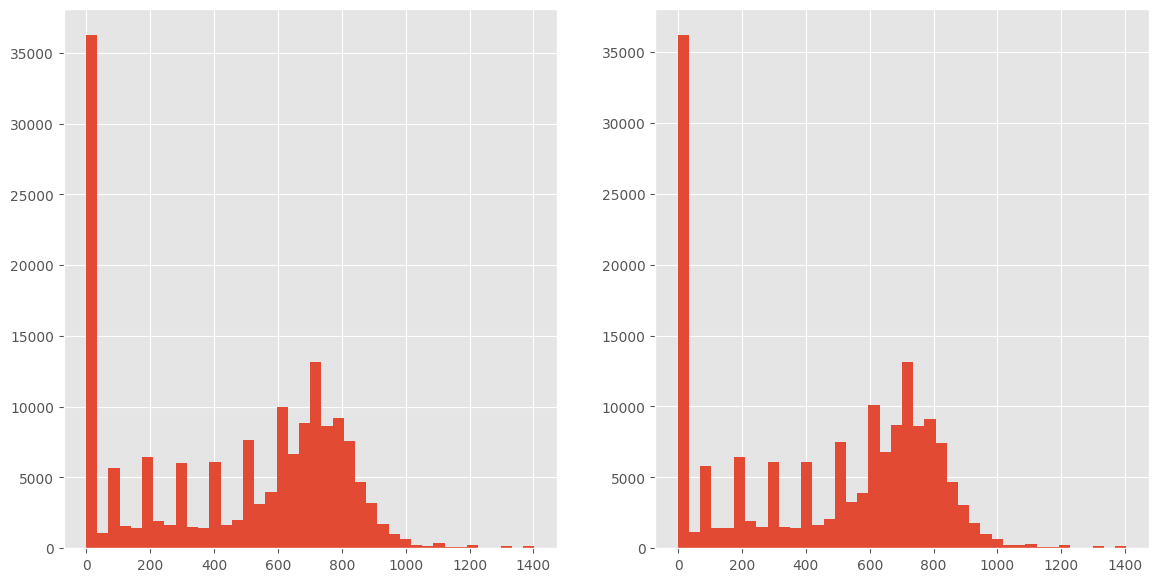

In [25]:
# plot trophies

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
ax1.hist(x=battlelogFinal['avg_brawler_trophies_team1'], bins=40)
ax2.hist(x=battlelogFinal['avg_brawler_trophies_team2'], bins=40)
plt.show()


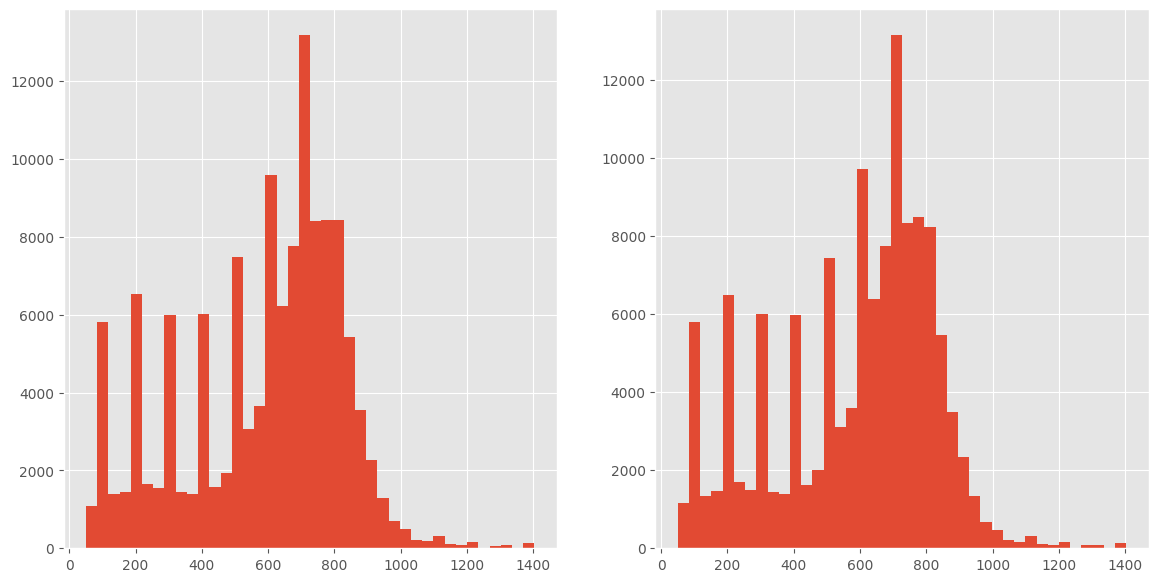

In [26]:

# subset avg trophies
battlelogFinal = battlelogFinal[(battlelogFinal['avg_brawler_trophies_team1'] > 50) & (battlelogFinal['avg_brawler_trophies_team2'] > 50)].reset_index(drop = True)

fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].hist(x=battlelogFinal['avg_brawler_trophies_team1'], bins=40)
ax[1].hist(x=battlelogFinal['avg_brawler_trophies_team2'], bins=40)
plt.show()

In [27]:
# order rows
def get_min_max_rest(row, column_names):
    a, b, c = row[column_names[0]], row[column_names[1]], row[column_names[2]]
    min_val = min(a, b, c)
    max_val = max(a, b, c)
    # rest_val = (a + b + c) - min_val - max_val
    # return min_val, max_val, rest_val
    return min_val, max_val

def order_rows(df, column, team):
	column_names = ['battle_' + team + '_player1_' + column, 'battle_' + team + '_player2_' + column, 'battle_' + team + '_player3_' + column]
	# min_vals, max_vals, rest_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	min_vals, max_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	return min_vals, max_vals

cols = ['brawler_Range_Num',
'brawler_trophies',
'brawler_Health',
'brawler_Speed_Num',
'brawler_winrate',
'brawler_winrate_overall',
'highestTrophies',
'trophies',
'expPoints',
'team_victories']

for col in cols:
	for team in ['team1', 'team2']:
		battlelogFinal['min_' + col + '_' + team], battlelogFinal['max_' + col + '_' + team] = order_rows(battlelogFinal, col, team)

In [28]:
# Transformar a log
def to_log(df, column):
	df[column] = np.log(df[column] + 1)
	return df[column]

cols = ['avg_brawler_trophies',
'min_brawler_trophies',
'max_brawler_trophies',
'avg_trophies',
'min_trophies',
'max_trophies',
'avg_highestTrophies',
'min_highestTrophies',
'max_highestTrophies',
'avg_brawler_Health',
'min_brawler_Health',
'max_brawler_Health',
'avg_brawler_Speed_Num',
'min_brawler_Speed_Num',
'max_brawler_Speed_Num',
'avg_team_victories',
'min_team_victories',
'max_team_victories',
'avg_expPoints',
'min_expPoints',
'max_expPoints',
]

cols_map = [
'barriers',
'barriers_center',
'bushes',
'bushes_center',
]

for col in cols:
	for team in ['team1', 'team2']:
		battlelogFinal[col + '_' + team] = to_log(battlelogFinal, col + '_' + team)

for col in cols_map:
	battlelogFinal[col] = to_log(battlelogFinal, col)

In [29]:
sns.set_palette("Blues")
sns.set(style="whitegrid")

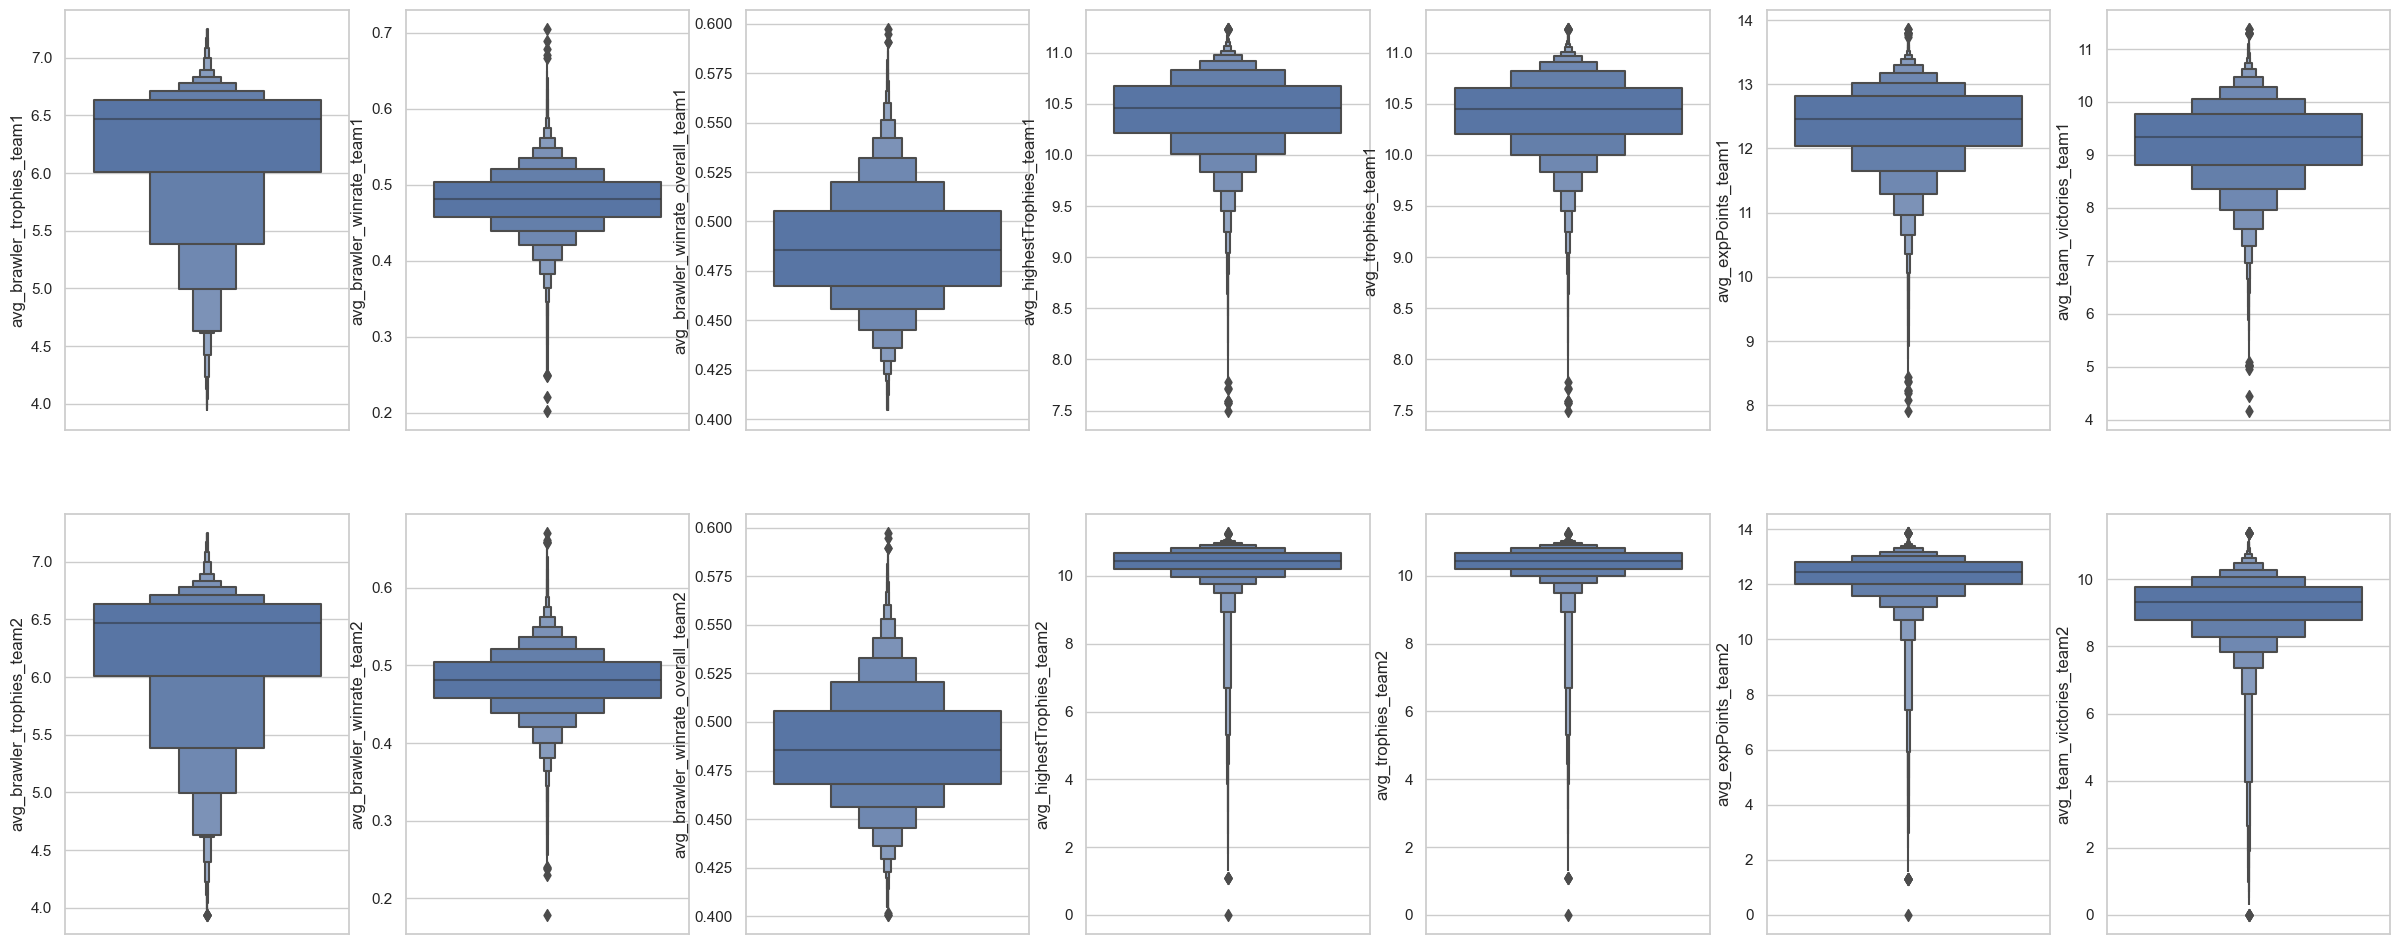

In [30]:
# graficar
cols = ['brawler_trophies',
'brawler_winrate',
'brawler_winrate_overall',
'highestTrophies',
'trophies',
'expPoints',
'team_victories']

fig, ax = plt.subplots(2, len(cols), figsize=(30, 12))
for i, col in enumerate(cols):
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['avg_' + col + '_' + team], ax=ax[j, i])

plt.show()

In [31]:
# funcion para dejar outliers con valor igual al umbral

def min_max_values(series, min_value, max_value):
    
    series = series.apply(lambda x: max_value if x > max_value else (min_value if x < min_value else x))
    
    return series


def eliminar_outliers(df, columna):
	q1 = df[columna].quantile(0.25)
	q3 = df[columna].quantile(0.75)
	iqr = q3 - q1
	umbral_inferior  = q1 - 1.5 * iqr
	umbral_superior = q3 + 1.5 * iqr
	df[columna] = min_max_values(df[columna], umbral_inferior, umbral_superior)
	return df

for col in cols:
	for team in ['team1', 'team2']:
		battlelogFinal = eliminar_outliers(battlelogFinal, 'avg_' + col + '_' + team)

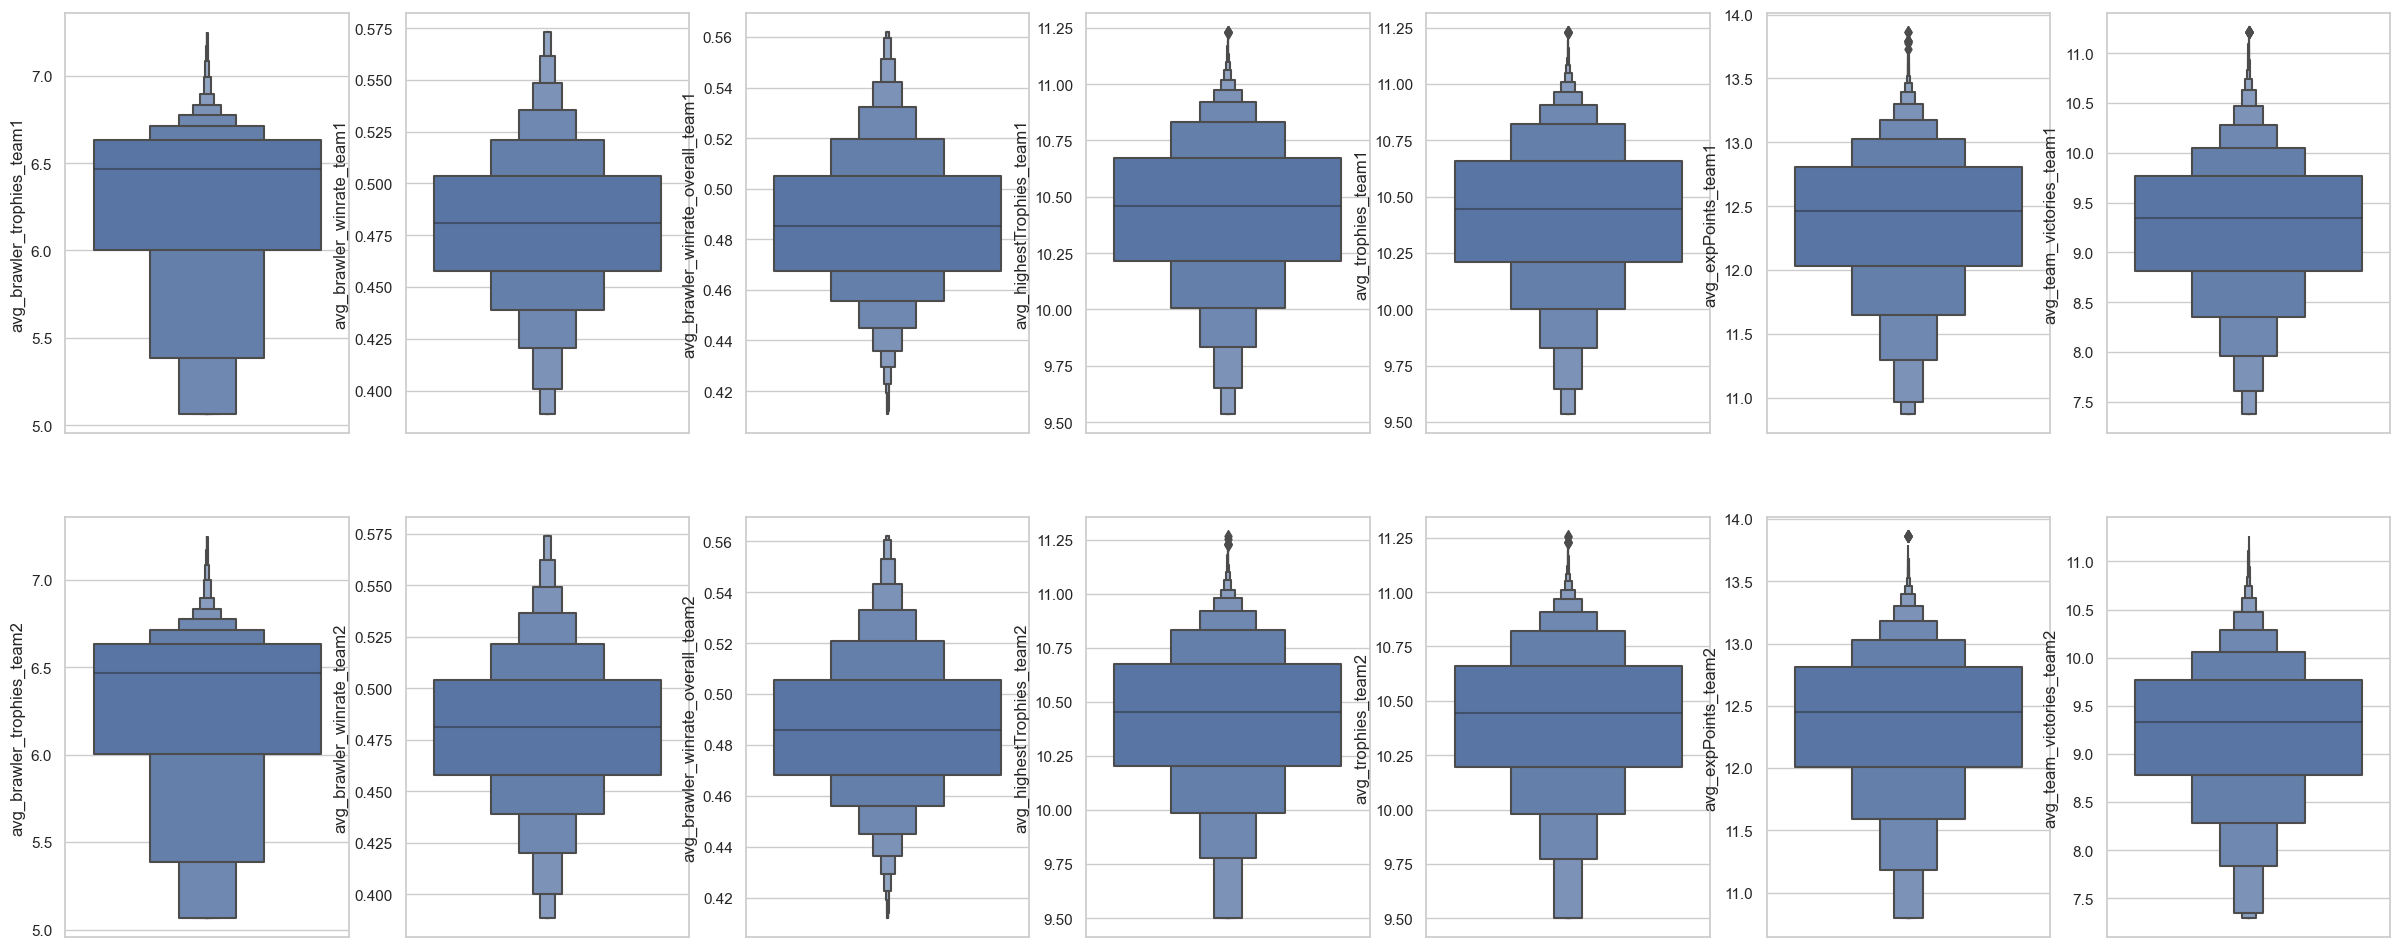

In [32]:
# graficar resultado
fig, ax = plt.subplots(2, len(cols), figsize=(30, 12))
for i, col in enumerate(cols):
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['avg_' + col + '_' + team], ax=ax[j, i])

plt.show()

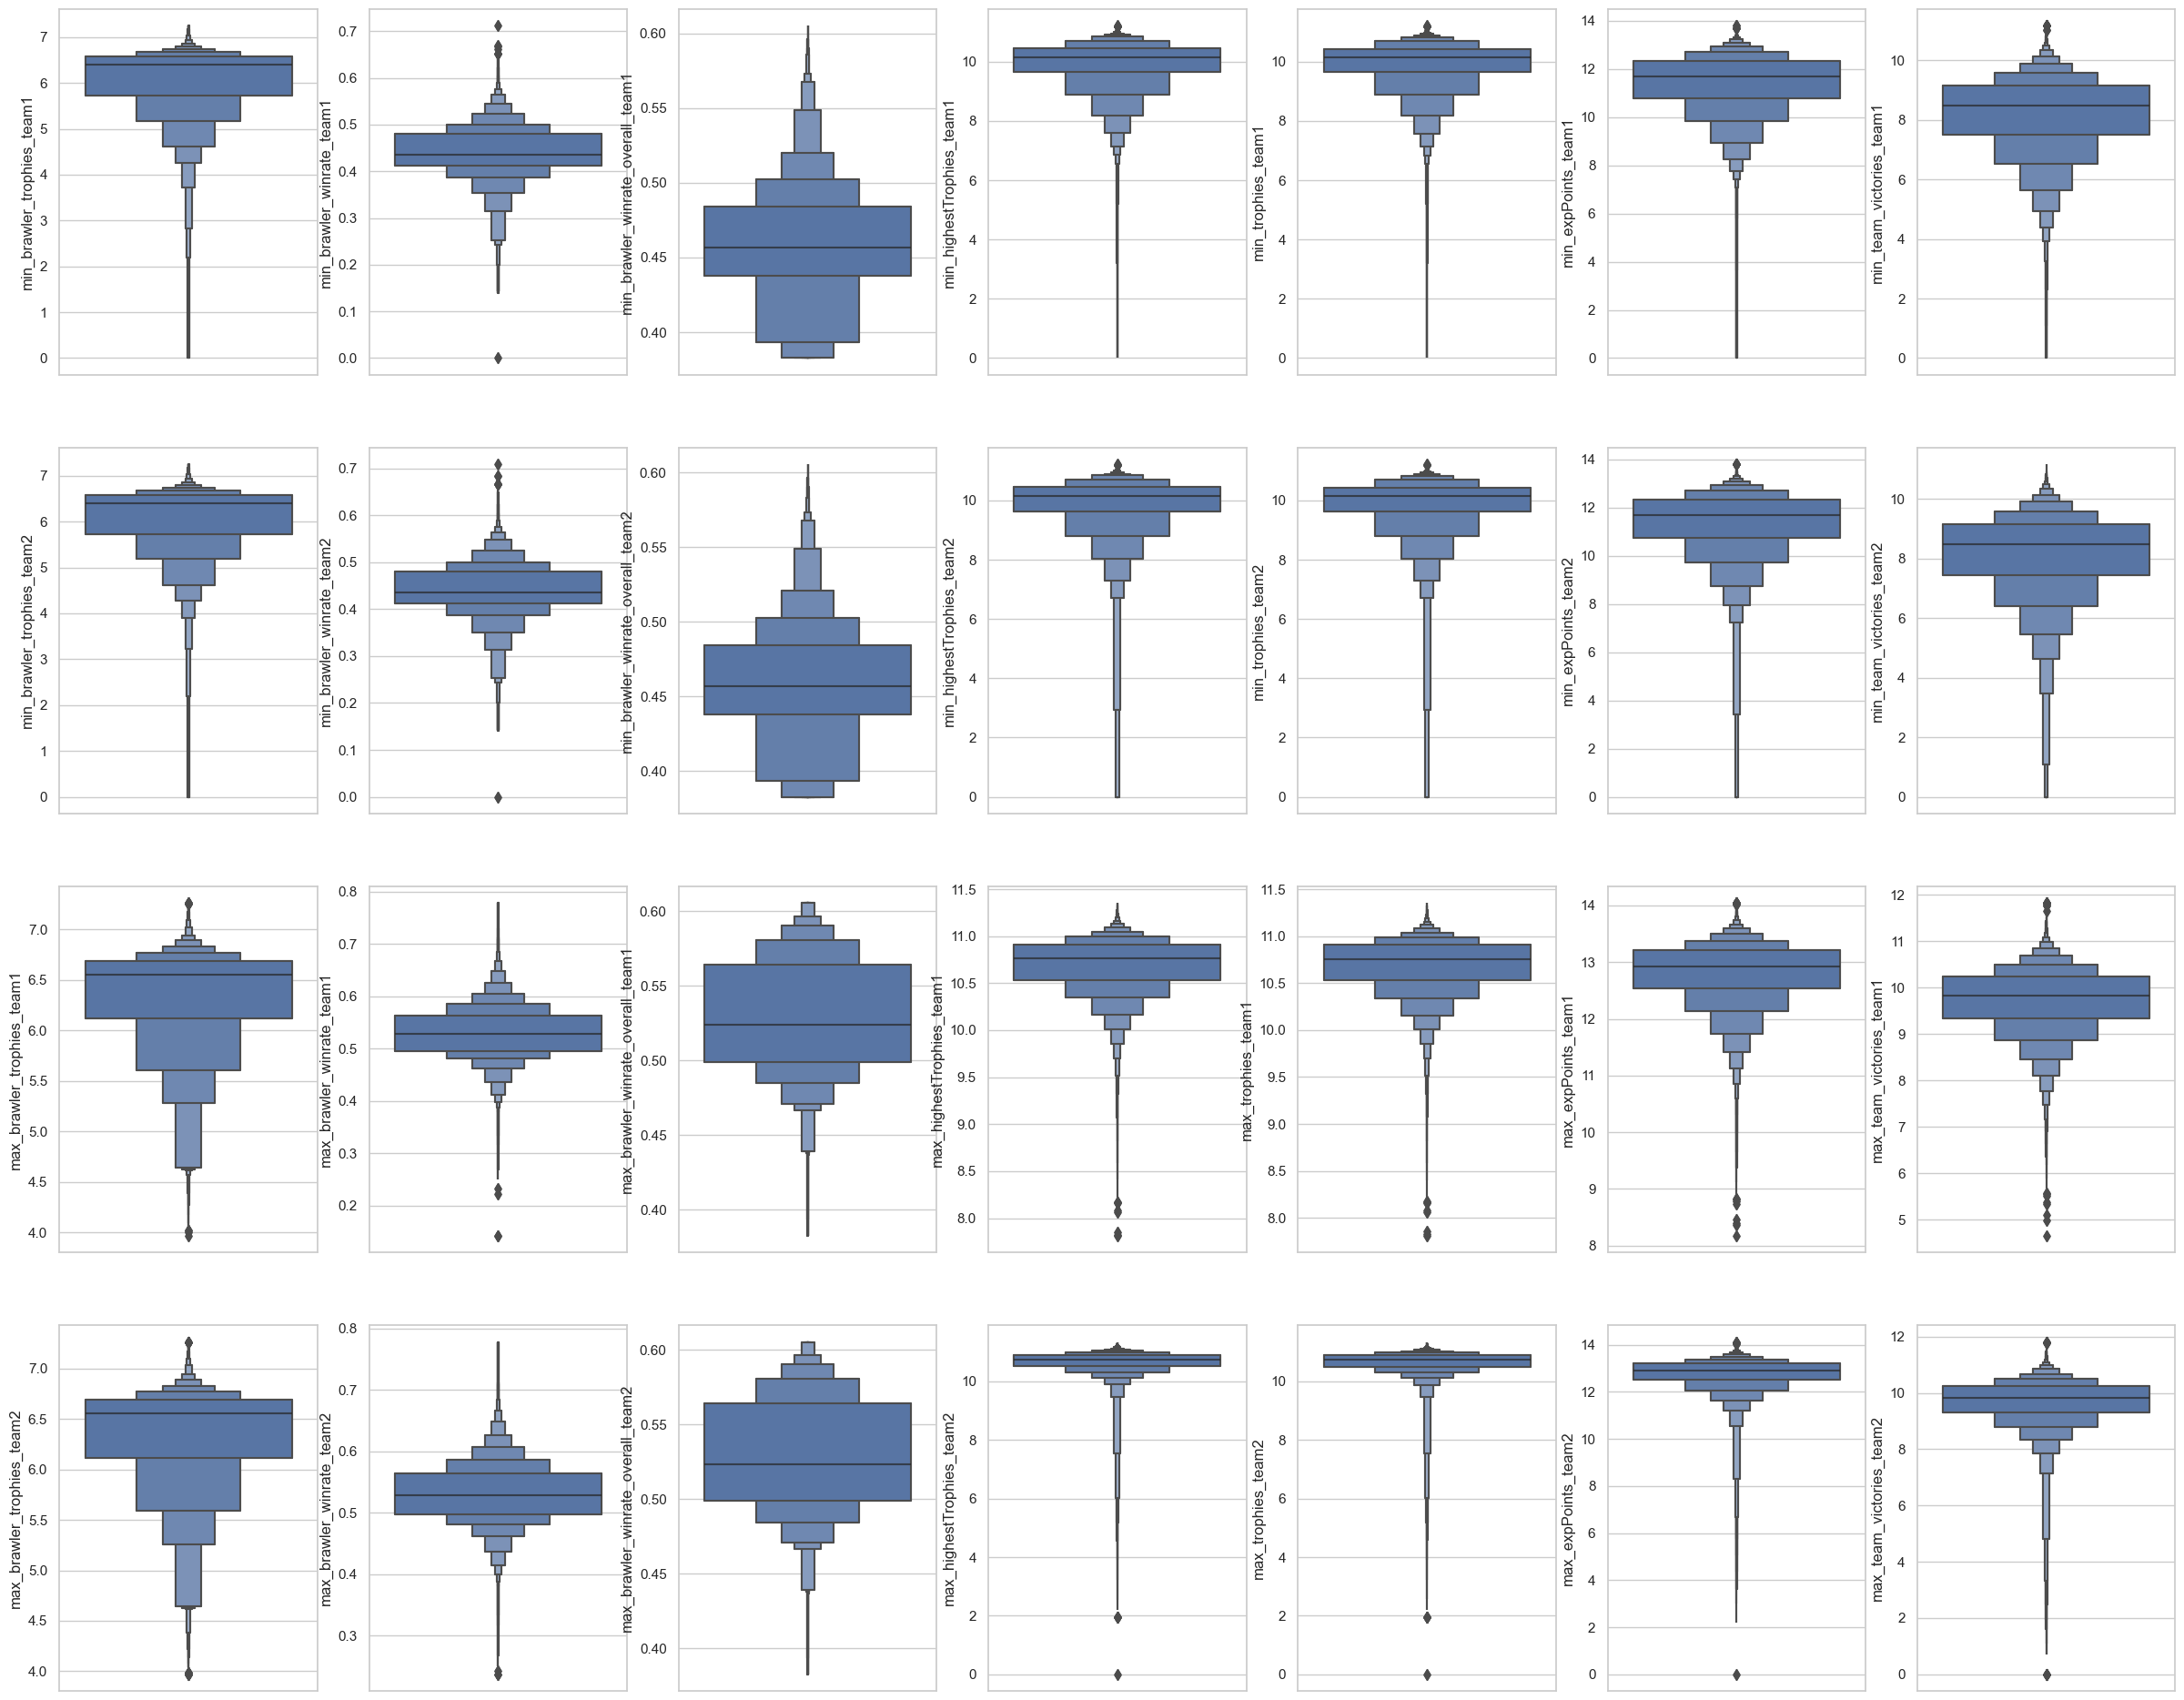

In [33]:
# graficar
fig, ax = plt.subplots(4, len(cols), figsize=(30, 24))
for i, col in enumerate(cols):
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['min_' + col + '_' + team], ax=ax[j, i])
        sns.boxenplot(y=battlelogFinal['min_' + col + '_' + team], ax=ax[j, i])
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['max_' + col + '_' + team], ax=ax[j+2, i])
        sns.boxenplot(y=battlelogFinal['max_' + col + '_' + team], ax=ax[j+2, i])

plt.show()

In [34]:
for col in cols:
	for team in ['team1', 'team2']:
		battlelogFinal = eliminar_outliers(battlelogFinal, 'min_' + col + '_' + team)
		battlelogFinal = eliminar_outliers(battlelogFinal, 'max_' + col + '_' + team)

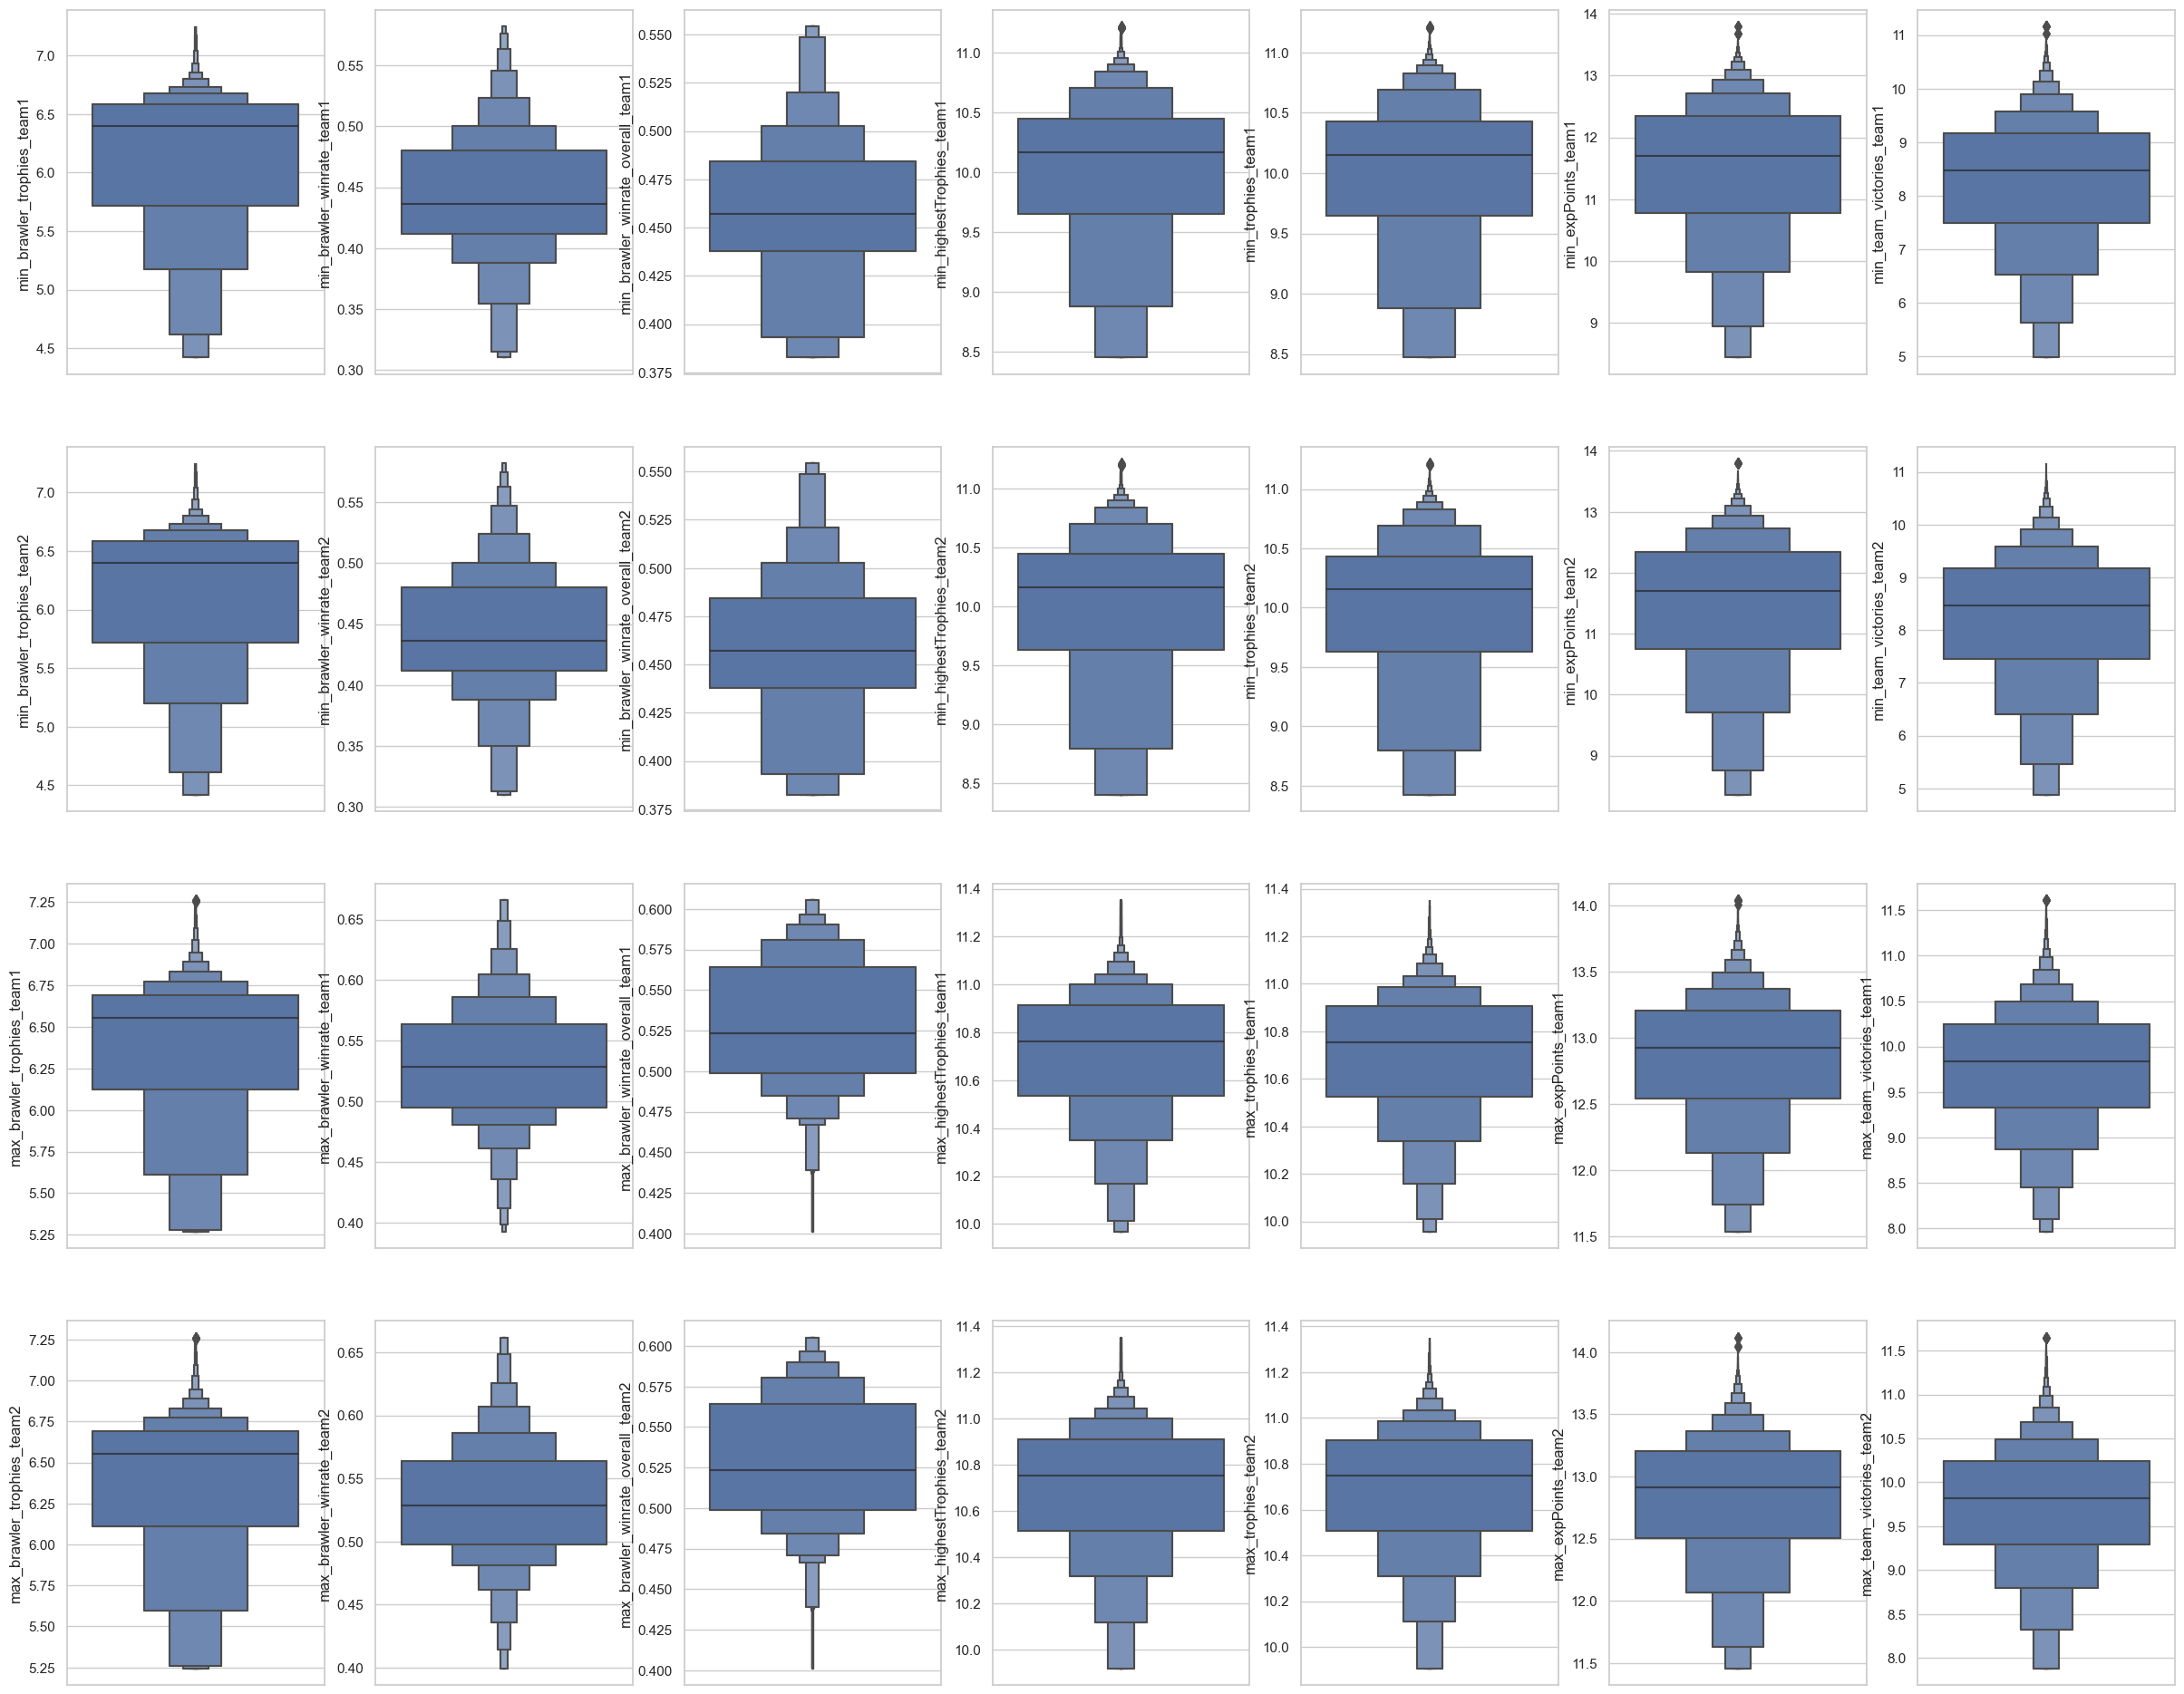

In [35]:
# graficar
fig, ax = plt.subplots(4, len(cols), figsize=(30, 24))
for i, col in enumerate(cols):
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['min_' + col + '_' + team], ax=ax[j, i])
        sns.boxenplot(y=battlelogFinal['min_' + col + '_' + team], ax=ax[j, i])
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['max_' + col + '_' + team], ax=ax[j+2, i])
        sns.boxenplot(y=battlelogFinal['max_' + col + '_' + team], ax=ax[j+2, i])

plt.show()

In [36]:
# power column merge
for team in ['team1', 'team2']:
    battlelogFinal['battle_power_' + team] = battlelogFinal['battle_' + team + '_player1_brawler_power'] + battlelogFinal['battle_' + team + '_player2_brawler_power'] + battlelogFinal['battle_' + team + '_player3_brawler_power']

In [37]:
# agregar diferencia de columnas

cols = [
    'avg_brawler_Range_Num',
	'avg_brawler_trophies',
	'avg_brawler_Health',
	'avg_brawler_Speed_Num',
	'avg_brawler_winrate',
	'avg_brawler_winrate_overall',
	'avg_highestTrophies',
	'avg_trophies',
	'avg_expPoints',
	'avg_team_victories',
	'max_brawler_Range_Num',
	'max_brawler_trophies',
	'max_brawler_Health',
	'max_brawler_Speed_Num',
	'max_brawler_winrate',
	'max_brawler_winrate_overall',
	'max_highestTrophies',
	'max_trophies',
	'max_expPoints',
	'max_team_victories',
	'min_brawler_Range_Num',
	'min_brawler_trophies',
	'min_brawler_Health',
	'min_brawler_Speed_Num',
	'min_brawler_winrate',
	'min_brawler_winrate_overall',
	'min_highestTrophies',
	'min_trophies',
	'min_expPoints',
	'min_team_victories',
	'battle_power',
]

for col in cols:
	battlelogFinal[col + '_diff'] = battlelogFinal[col + '_team1'] - battlelogFinal[col + '_team2']

In [38]:
# assign correct dtypes
dtypes = {
	'event_mode': 'category',
	'event_map': 'category',
	'battle_team1_player1_brawler_name': 'category',
	'battle_team1_player2_brawler_name': 'category',
	'battle_team1_player3_brawler_name': 'category',
	'battle_team2_player1_brawler_name': 'category',
	'battle_team2_player2_brawler_name': 'category',
	'battle_team2_player3_brawler_name': 'category',
	'battle_team1_player1_brawler_Class': 'category',
	'battle_team1_player2_brawler_Class': 'category',
	'battle_team1_player3_brawler_Class': 'category',
	'battle_team2_player1_brawler_Class': 'category',
	'battle_team2_player2_brawler_Class': 'category',
	'battle_team2_player3_brawler_Class': 'category',
	'battle_team1_player1_brawler_Role': 'category',
	'battle_team1_player2_brawler_Role': 'category',
	'battle_team1_player3_brawler_Role': 'category',
	'battle_team2_player1_brawler_Role': 'category',
	'battle_team2_player2_brawler_Role': 'category',
	'battle_team2_player3_brawler_Role': 'category',
	'battle_team1_player1_brawler_Movement_Speed': 'category',
	'battle_team1_player2_brawler_Movement_Speed': 'category',
	'battle_team1_player3_brawler_Movement_Speed': 'category',
	'battle_team2_player1_brawler_Movement_Speed': 'category',
	'battle_team2_player2_brawler_Movement_Speed': 'category',
	'battle_team2_player3_brawler_Movement_Speed': 'category',
	'battle_team1_player1_brawler_Range': 'category',
	'battle_team1_player2_brawler_Range': 'category',
	'battle_team1_player3_brawler_Range': 'category',
	'battle_team2_player1_brawler_Range': 'category',
	'battle_team2_player2_brawler_Range': 'category',
	'battle_team2_player3_brawler_Range': 'category',
	'waterProp': 'float32',
	'avg_brawler_Range_Num_team1': 'float32',
	'avg_brawler_Range_Num_team2': 'float32',
	'avg_brawler_trophies_team1': 'float32',
	'avg_brawler_trophies_team2': 'float32',
	'avg_brawler_Health_team1': 'float32',
	'avg_brawler_Health_team2': 'float32',
	'avg_brawler_Speed_Num_team1': 'float32',
	'avg_brawler_Speed_Num_team2': 'float32',
	'avg_brawler_winrate_team1': 'float32',
	'avg_brawler_winrate_team2': 'float32',
	'avg_brawler_winrate_overall_team1': 'float32',
	'avg_brawler_winrate_overall_team2': 'float32',
	'avg_highestTrophies_team1': 'float32',
	'avg_highestTrophies_team2': 'float32',
	'avg_trophies_team1': 'float32',
	'avg_trophies_team2': 'float32',
	'avg_expPoints_team1': 'float32',
	'avg_expPoints_team2': 'float32',
	'avg_team_victories_team1': 'float32',
	'avg_team_victories_team2': 'float32',
	'max_brawler_Range_Num_team1': 'float32',
	'max_brawler_Range_Num_team2': 'float32',
	'max_brawler_trophies_team1': 'float32',
	'max_brawler_trophies_team2': 'float32',
	'max_brawler_Health_team1': 'float32',
	'max_brawler_Health_team2': 'float32',
	'max_brawler_Speed_Num_team1': 'float32',
	'max_brawler_Speed_Num_team2': 'float32',
	'max_brawler_winrate_team1': 'float32',
	'max_brawler_winrate_team2': 'float32',
	'max_brawler_winrate_overall_team1': 'float32',
	'max_brawler_winrate_overall_team2': 'float32',
	'max_highestTrophies_team1': 'float32',
	'max_highestTrophies_team2': 'float32',
	'max_trophies_team1': 'float32',
	'max_trophies_team2': 'float32',
	'max_expPoints_team1': 'float32',
	'max_expPoints_team2': 'float32',
	'max_team_victories_team1': 'float32',
	'max_team_victories_team2': 'float32',
	'min_brawler_Range_Num_team1': 'float32',
	'min_brawler_Range_Num_team2': 'float32',
	'min_brawler_trophies_team1': 'float32',
	'min_brawler_trophies_team2': 'float32',
	'min_brawler_Health_team1': 'float32',
	'min_brawler_Health_team2': 'float32',
	'min_brawler_Speed_Num_team1': 'float32',
	'min_brawler_Speed_Num_team2': 'float32',
	'min_brawler_winrate_team1': 'float32',
	'min_brawler_winrate_team2': 'float32',
	'min_brawler_winrate_overall_team1': 'float32',
	'min_brawler_winrate_overall_team2': 'float32',
	'min_highestTrophies_team1': 'float32',
	'min_highestTrophies_team2': 'float32',
	'min_trophies_team1': 'float32',
	'min_trophies_team2': 'float32',
	'min_expPoints_team1': 'float32',
	'min_expPoints_team2': 'float32',
	'min_team_victories_team1': 'float32',
	'min_team_victories_team2': 'float32',
	'battle_power_team1': 'float32',
	'battle_power_team2': 'float32',
	'avg_brawler_Range_Num_diff': 'float32',
	'avg_brawler_trophies_diff': 'float32',
	'avg_brawler_Health_diff': 'float32',
	'avg_brawler_Speed_Num_diff': 'float32',
	'avg_brawler_winrate_diff': 'float32',
	'avg_brawler_winrate_overall_diff': 'float32',
	'avg_highestTrophies_diff': 'float32',
	'avg_trophies_diff': 'float32',
	'avg_expPoints_diff': 'float32',
	'avg_team_victories_diff': 'float32',
	'max_brawler_Range_Num_diff': 'float32',
	'max_brawler_trophies_diff': 'float32',
	'max_brawler_Health_diff': 'float32',
	'max_brawler_Speed_Num_diff': 'float32',
	'max_brawler_winrate_diff': 'float32',
	'max_brawler_winrate_overall_diff': 'float32',
	'max_highestTrophies_diff': 'float32',
	'max_trophies_diff': 'float32',
	'max_expPoints_diff': 'float32',
	'max_team_victories_diff': 'float32',
	'min_brawler_Range_Num_diff': 'float32',
	'min_brawler_trophies_diff': 'float32',
	'min_brawler_Health_diff': 'float32',
	'min_brawler_Speed_Num_diff': 'float32',
	'min_brawler_winrate_diff': 'float32',
	'min_brawler_winrate_overall_diff': 'float32',
	'min_highestTrophies_diff': 'float32',
	'min_trophies_diff': 'float32',
	'min_expPoints_diff': 'float32',
	'min_team_victories_diff': 'float32',
	'battle_power_diff': 'float32',
	'winner_team': 'int8',
	'barriers': 'int8',
	'barriers_center': 'int8',
	'bushes': 'int8',
	'bushes_center': 'int8',
}

battlelogFinal = battlelogFinal.astype(dtypes)

In [39]:
# export to parquet
battlelogFinal.to_parquet('datasets/teams/battlelog_train.parquet', index=False, compression='gzip')

In [46]:
# get average of each brawler stat

def get_means(column):
    return np.mean(
		battlelogFinal['battle_team1_player1_' + column].to_list() + 
		battlelogFinal['battle_team1_player2_' + column].to_list() + 
		battlelogFinal['battle_team1_player3_' + column].to_list() +
		battlelogFinal['battle_team2_player1_' + column].to_list() +
		battlelogFinal['battle_team2_player2_' + column].to_list() +
		battlelogFinal['battle_team2_player3_' + column].to_list()
	)
mean_brawler_trophies = get_means('brawler_trophies')

mean_brawler_power = get_means('brawler_power')

mean_trophies = get_means('trophies')

mean_highestTrophies = get_means('highestTrophies')

mean_expPoints = get_means('expPoints')

mean_team_victories = get_means('team_victories')

dict_means = {
	'mean_brawler_trophies': mean_brawler_trophies,
	'mean_brawler_power': mean_brawler_power,
	'mean_trophies': mean_trophies,
	'mean_highestTrophies': mean_highestTrophies,
	'mean_expPoints': mean_expPoints,
	'mean_team_victories': mean_team_victories,
}

means = pd.DataFrame(dict_means, index=[0])
means.to_json('resources/means.json', orient='records')

means

,mean_brawler_trophies,mean_brawler_power,mean_trophies,mean_highestTrophies,mean_expPoints,mean_team_victories
0,583.938588,10.388948,35055.187744,35423.589749,276049.471666,13257.765495


In [103]:
sns.set_style('darkgrid')
sns.set_palette('muted')

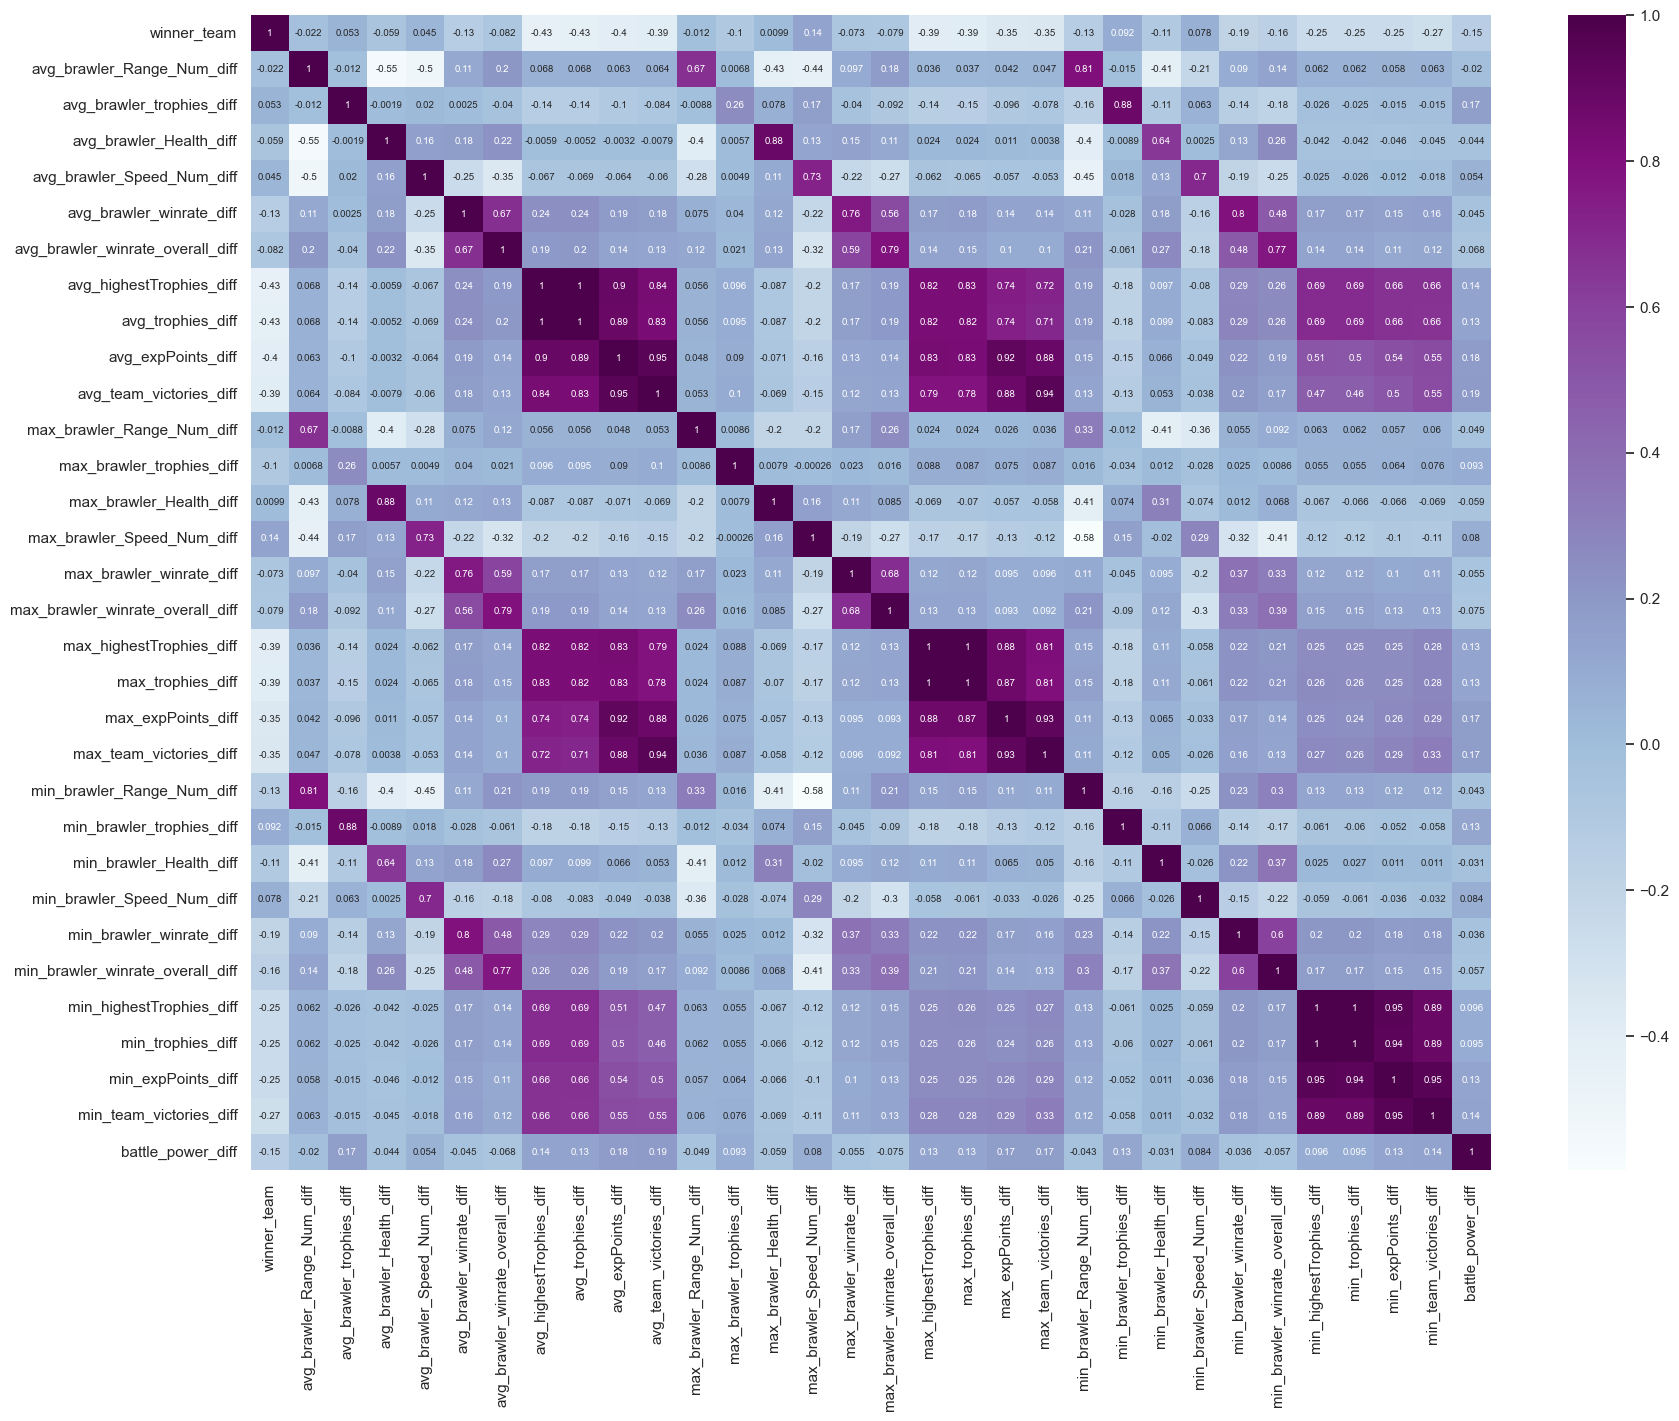

In [104]:
# heatmap de correlaciones

cols=[
    'winner_team',
    'avg_brawler_Range_Num_diff',
	'avg_brawler_trophies_diff',
	'avg_brawler_Health_diff',
	'avg_brawler_Speed_Num_diff',
	'avg_brawler_winrate_diff',
	'avg_brawler_winrate_overall_diff',
	'avg_highestTrophies_diff',
	'avg_trophies_diff',
	'avg_expPoints_diff',
	'avg_team_victories_diff',
	'max_brawler_Range_Num_diff',
	'max_brawler_trophies_diff',
	'max_brawler_Health_diff',
	'max_brawler_Speed_Num_diff',
	'max_brawler_winrate_diff',
	'max_brawler_winrate_overall_diff',
	'max_highestTrophies_diff',
	'max_trophies_diff',
	'max_expPoints_diff',
	'max_team_victories_diff',
	'min_brawler_Range_Num_diff',
	'min_brawler_trophies_diff',
	'min_brawler_Health_diff',
	'min_brawler_Speed_Num_diff',
	'min_brawler_winrate_diff',
	'min_brawler_winrate_overall_diff',
	'min_highestTrophies_diff',
	'min_trophies_diff',
	'min_expPoints_diff',
	'min_team_victories_diff',
	'battle_power_diff',
]

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(battlelogFinal[cols].corr(numeric_only=True), annot=True, annot_kws={"size": 7}, cmap='BuPu', ax=ax)
plt.show()

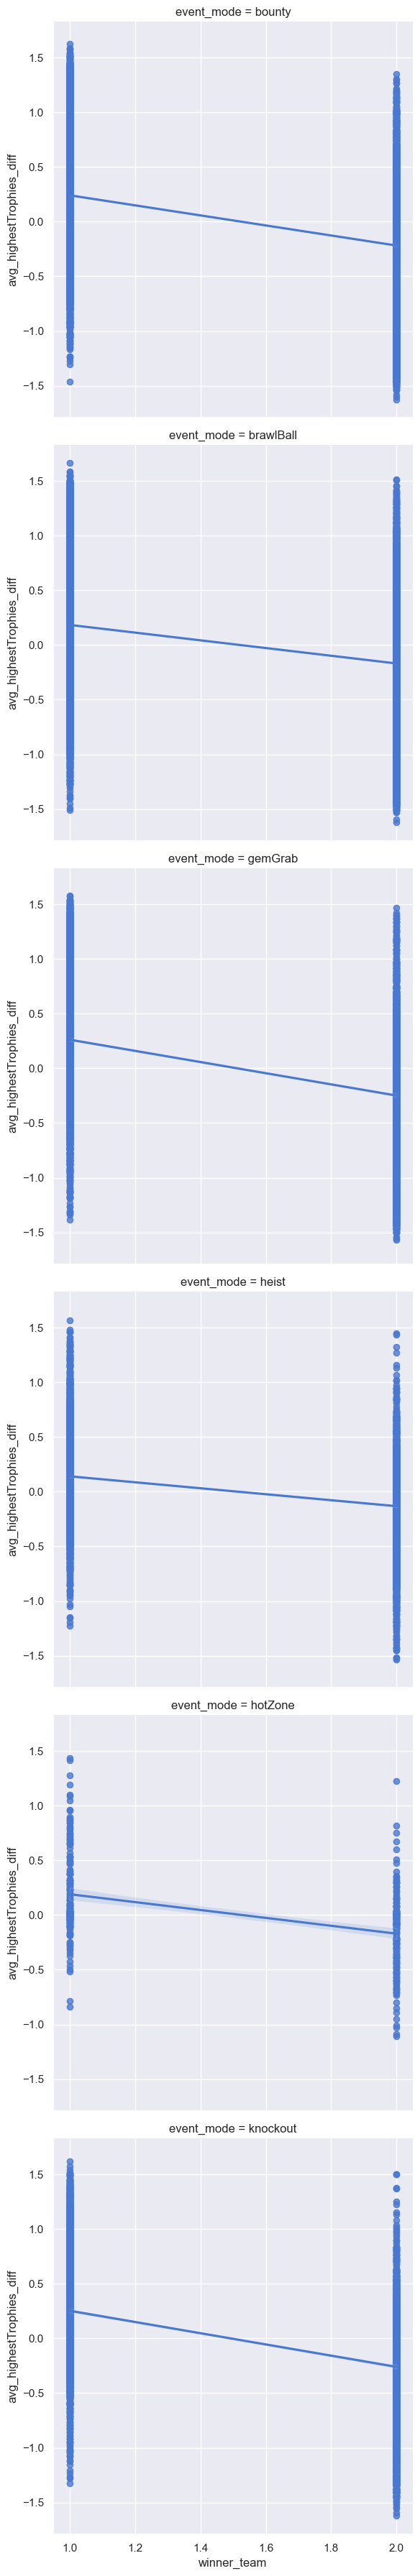

In [105]:
# graficar relacion entre columnas
sns.lmplot(data=battlelogFinal, x='winner_team', y='avg_highestTrophies_diff', row='event_mode', height=6)
sns.despine(left=False, bottom=False)
plt.show()

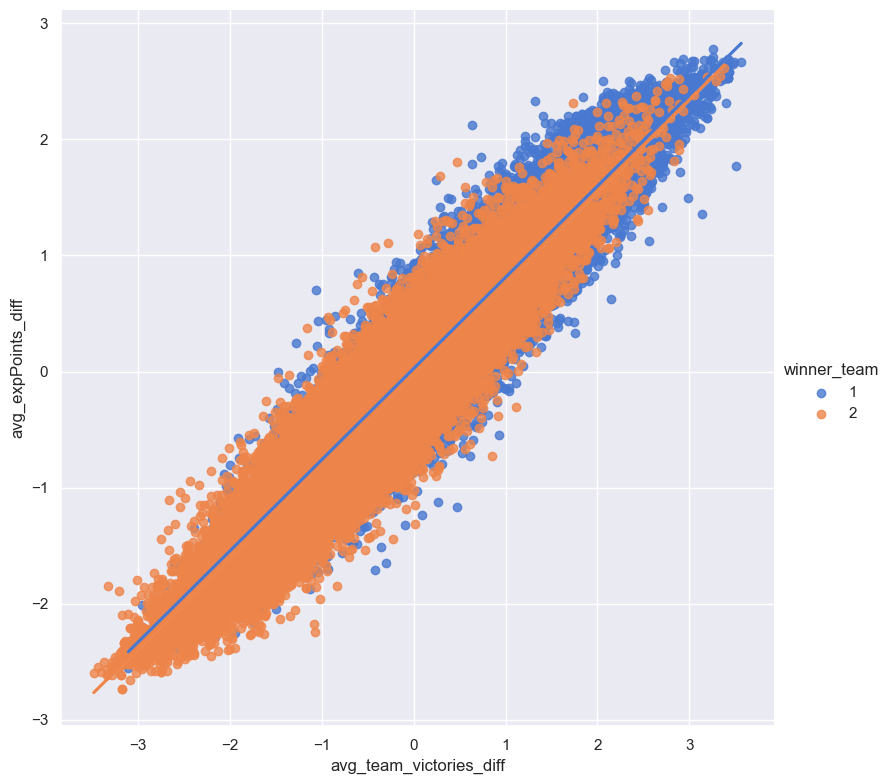

In [106]:
sns.lmplot(data=battlelogFinal, x='avg_team_victories_diff', y='avg_expPoints_diff', hue='winner_team', height=8)
plt.show()